In [1]:
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
protein_sequences_labelled = pd.read_csv("protein_sequences_labelled.csv")

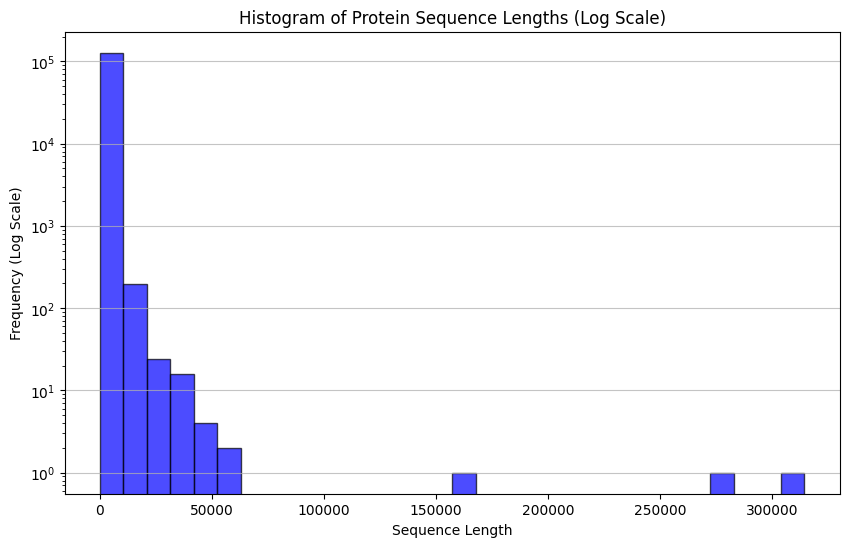

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your DataFrame (replace with your actual DataFrame)
# protein_sequences_labelled = pd.read_csv("protein_sequences_labelled.csv")

# Calculate the lengths of each sequence
lengths = protein_sequences_labelled['concatenated_sequence'].apply(len)

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=30, color='blue', alpha=0.7, edgecolor='black')  # Adjust bins as needed

# Set logarithmic scale for the y-axis
plt.yscale('log')

plt.title('Histogram of Protein Sequence Lengths (Log Scale)')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency (Log Scale)')
plt.grid(axis='y', alpha=0.75)
plt.show()


In [4]:
threshold = 100000 # Set your desired threshold

# Remove rows where the length of the 'concatenated_sequence' exceeds the threshold
protein_sequences_labelled = protein_sequences_labelled[
    protein_sequences_labelled['concatenated_sequence'].apply(len) <= threshold
]

# Optional: Check the shape of the DataFrame after filtering
print(f"Remaining rows: {protein_sequences_labelled.shape[0]}")

Remaining rows: 127789


In [5]:
protein_seq_by_type = protein_sequences_labelled.groupby('classification')['concatenated_sequence'].apply(list).to_dict()

In [6]:
all_sequences = ''.join(protein_sequences_labelled['concatenated_sequence'].values)
all_characters = list(set(all_sequences)) + ["PAD"]
character_index = {char: all_characters.index(char) for char in all_characters}
n_characters = len(all_characters)
all_protein_classifications = protein_sequences_labelled['classification'].unique().tolist()
n_classifications = len(all_protein_classifications)

In [7]:
# character_index

In [8]:
def AA_to_index(AA):
    return character_index[AA]

def AA_to_tensor(AA):
    tensor = torch.zeros(1, n_characters)
    tensor[0][AA_to_index(AA)] = 1
    return tensor

def polypeptide_to_tensor(polypeptide):
    tensor = torch.zeros(len(polypeptide), n_characters)  # Remove extra dimension
    for index, AA in enumerate(polypeptide):
        tensor[index][AA_to_index(AA)] = 1  # Set the corresponding index to 1
    return tensor

In [9]:
class ProteinDataset(Dataset):
    def __init__(self, protein_sequences_labelled, transform=None, target_transform=None):
        self.protein_sequences_labelled = protein_sequences_labelled
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.protein_sequences_labelled)
    
    def __getitem__(self, idx):
        row = self.protein_sequences_labelled.iloc[idx]
        protein_sequence = row['concatenated_sequence']
        label = row['classification']
       
        if self.transform:
            sequence_tensor = self.transform(protein_sequence)
        else:
            sequence_tensor = polypeptide_to_tensor(protein_sequence)

        if self.target_transform:
            label = self.target_transform(label)
        else:
            label = torch.tensor([all_protein_classifications.index(label)], dtype=torch.long)

        return sequence_tensor, label

In [10]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

data = ProteinDataset(protein_sequences_labelled)

def collate_fn(batch):
    # Unzip the batch into sequences and labels
    sequences, labels = zip(*batch)
    
    # for sequence in sequences:
        # print(sequence.shape)
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=character_index["PAD"])
    
    stacked_labels = torch.cat(labels) 

    return padded_sequences, stacked_labels

dataloader = DataLoader(data, batch_size=16, shuffle=True, collate_fn=collate_fn)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # No softmax - using cross-entropy loss

    def forward(self, x):
        out, hidden = self.rnn(x)  
        out = out[:, -1, :]  
        out = self.fc(out)  
        return out

n_hidden = 128
rnn = RNN(n_characters, n_hidden, n_classifications).to(device)

In [12]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def train(dataloader, model, criterion, optimizer, num_epochs):
    model.train()  # Set the model to training mode
    all_losses = []  # To store the loss for each batch

    for epoch in range(num_epochs):
        total_loss = 0.0
        epoch_losses = []  # Track the loss for this epoch
        with tqdm(total=len(dataloader), desc="Training Progress", unit='batch') as pbar:
            for line_tensor, category_tensor in dataloader:
                optimizer.zero_grad()

                # Move data to the appropriate device
                line_tensor = line_tensor.to(device).contiguous()
                category_tensor = category_tensor.to(device)
                # if line_tensor.shape[1] > 50000:
                #     print(f'Input shape: {line_tensor.shape}')
                # # print(f'Input dtype: {line_tensor.dtype}')
                # # print(f'Label shape: {category_tensor.shape}')
                # # print(f'Label dtype: {category_tensor.dtype}')
                # # Forward pass through the model
                output = model(line_tensor)
                
                # Compute loss
                loss = criterion(output, category_tensor)
                epoch_losses.append(loss.item())  # Save batch loss for this epoch
                
                # Backpropagation and optimization step
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

                pbar.set_postfix(loss=loss.item())
                pbar.update(1) 

        # After each epoch, store the average loss
        all_losses.append(sum(epoch_losses) / len(epoch_losses))
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {all_losses[-1]}")

    return all_losses  # Return all the epoch losses for plotting


In [13]:
import torch.nn as nn

num_epochs = 10  # Set the number of epochs
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

losses = train(dataloader, rnn, criterion=criterion, optimizer=optimizer, num_epochs=num_epochs)


Training Progress: 100%|██████████| 7987/7987 [11:19<00:00, 11.75batch/s, loss=3.43]


Epoch 1/10, Loss: 4.516649127111009


Training Progress: 100%|██████████| 7987/7987 [11:13<00:00, 11.87batch/s, loss=3.16]


Epoch 2/10, Loss: 4.445678093682037


Training Progress: 100%|██████████| 7987/7987 [11:16<00:00, 11.80batch/s, loss=3.33]


Epoch 3/10, Loss: 4.444143994334823


Training Progress: 100%|██████████| 7987/7987 [11:12<00:00, 11.87batch/s, loss=5.75]


Epoch 4/10, Loss: 4.443647053269491


Training Progress: 100%|██████████| 7987/7987 [11:12<00:00, 11.87batch/s, loss=4.13]


Epoch 5/10, Loss: 4.441364088090711


Training Progress: 100%|██████████| 7987/7987 [11:32<00:00, 11.54batch/s, loss=3.79]  


Epoch 6/10, Loss: 4.4388610511305515


Training Progress: 100%|██████████| 7987/7987 [11:29<00:00, 11.58batch/s, loss=5.46]  


Epoch 7/10, Loss: 4.4357518832764455


Training Progress: 100%|██████████| 7987/7987 [11:16<00:00, 11.81batch/s, loss=4.98]  


Epoch 8/10, Loss: 4.437495410464741


Training Progress: 100%|██████████| 7987/7987 [11:28<00:00, 11.60batch/s, loss=4.88]  


Epoch 9/10, Loss: 4.4343420565762655


Training Progress: 100%|██████████| 7987/7987 [45:26<00:00,  2.93batch/s, loss=4.98]     

Epoch 10/10, Loss: 4.433711126747098


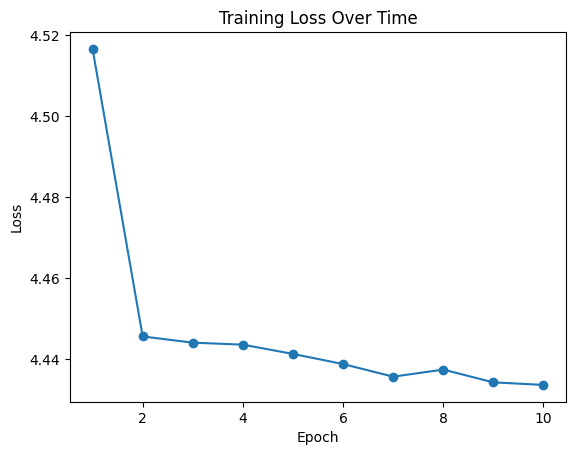

In [14]:
plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

Evaluating for confusion matrix: 100%|██████████| 7987/7987 [48:36<00:00,  2.74it/s]    
Locator attempting to generate 4470 ticks ([-1.0, ..., 4468.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 4470 ticks ([-1.0, ..., 4468.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 4470 ticks ([-1.0, ..., 4468.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 4470 ticks ([-1.0, ..., 4468.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 4470 ticks ([-1.0, ..., 4468.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 4470 ticks ([-1.0, ..., 4468.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 4470 ticks ([-1.0, ..., 4468.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 4470 ticks ([-1.0, ..., 4468.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 4470 ticks ([-1.0, ..., 4468.0]), which exceeds 

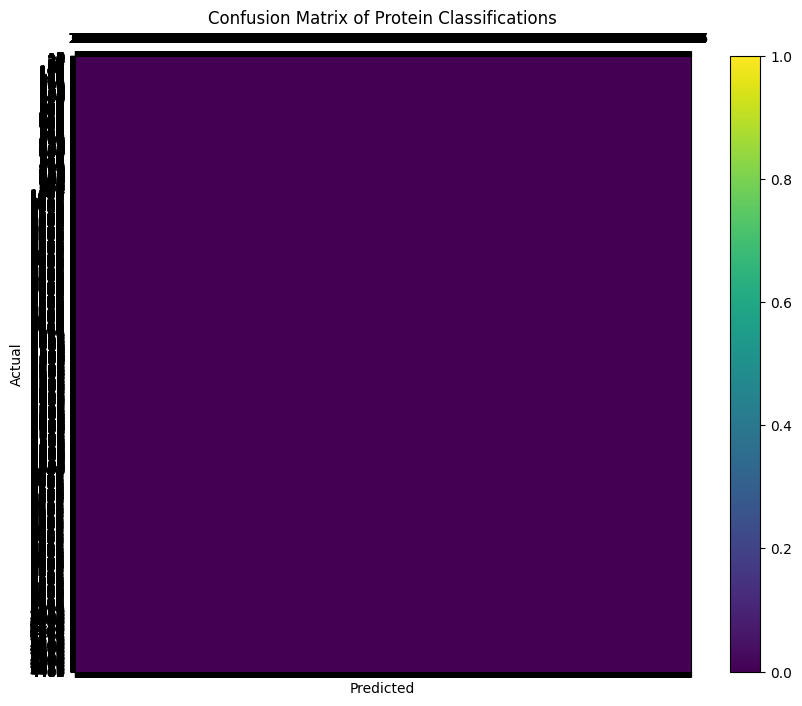

In [16]:
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tqdm import tqdm

# Initialize confusion matrix with zeros
confusion = torch.zeros(n_classifications, n_classifications)

# Number of examples to evaluate (can be total dataset or a subset)
n_confusion = len(dataloader.dataset)

# Function to evaluate a batch of sequences
def evaluate_batch(batch_sequences):
    with torch.no_grad():
        output = rnn(batch_sequences.to(device))
    return output

# Go through the dataloader and record guesses
for sequences, labels in tqdm(dataloader, desc="Evaluating for confusion matrix"):
    output = evaluate_batch(sequences)  # Get output from RNN
    _, predicted = torch.max(output, 1)  # Get the predicted class
    for i in range(labels.size(0)):  # Loop over each sequence in the batch
        actual_class = labels[i].item()
        predicted_class = predicted[i].item()
        confusion[actual_class][predicted_class] += 1  # Update confusion matrix

# Normalize by dividing each row by its sum
for i in range(n_classifications):
    confusion[i] = confusion[i] / confusion[i].sum()

# Plotting confusion matrix
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.cpu().numpy())  
fig.colorbar(cax)

plt.title('Confusion Matrix of Protein Classifications')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [17]:
torch.save(rnn.state_dict(), 'model_state_dict.pth')